In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1950_bacteria_4881.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/PNEUMONIA/processed_person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/NORMAL/processed_NORMAL2-IM-1430-0001.jpeg
/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val/NORMAL/processed_NORMAL2-IM-1431-0001.jpeg
/kaggle/input/chest-xray-ahe/Chest

In [3]:
train_dir = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/train'
test_dir = '/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/test'
val_dir ='/kaggle/input/chest-xray-ahe/Chest-Xray_AHE/val'

In [4]:
image_size = 160
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(image_size, image_size),
                                                                 batch_size = batch_size,
                                                                 shuffle = True)
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                               image_size=(image_size, image_size),
                                                               batch_size = batch_size,
                                                               shuffle = False)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [5]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [6]:
class_names = train_data.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


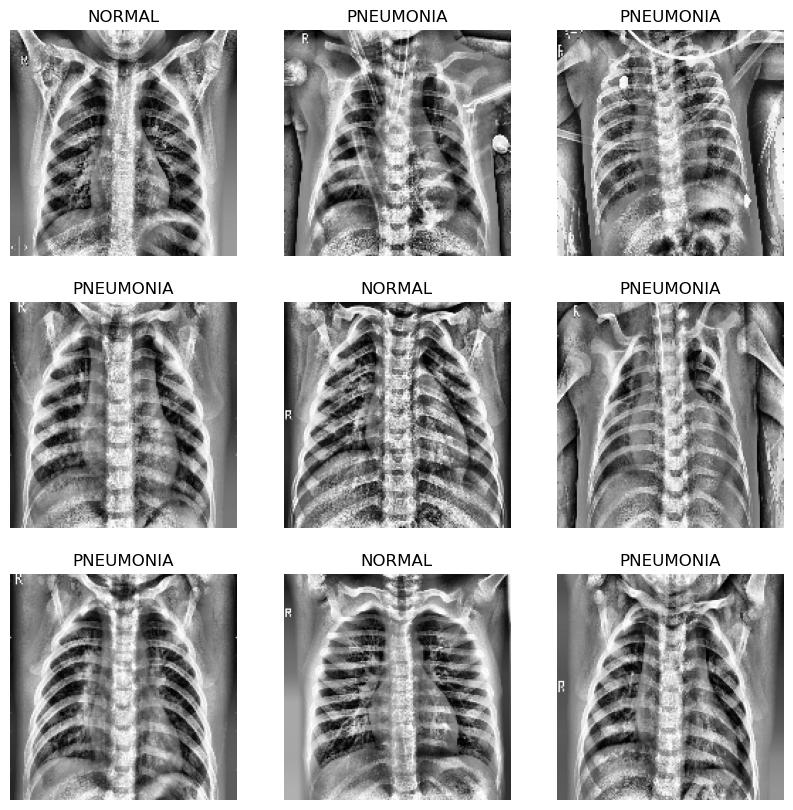

In [7]:
plt.figure(figsize = (10,10))

for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [8]:
image_batch

<tf.Tensor: shape=(32, 160, 160, 3), dtype=float32, numpy=
array([[[[  0.9937501,   0.9937501,   0.9937501],
         [ 12.324999 ,  12.324999 ,  12.324999 ],
         [ 24.438282 ,  24.438282 ,  24.438282 ],
         ...,
         [ 21.371094 ,  21.371094 ,  21.371094 ],
         [ 81.31599  ,  81.31599  ,  81.31599  ],
         [126.705925 , 126.705925 , 126.705925 ]],

        [[  2.0567188,   2.0567188,   2.0567188],
         [ 16.529219 ,  16.529219 ,  16.529219 ],
         [ 38.976566 ,  38.976566 ,  38.976566 ],
         ...,
         [ 24.41406  ,  24.41406  ,  24.41406  ],
         [ 56.047092 ,  56.047092 ,  56.047092 ],
         [203.53026  , 203.53026  , 203.53026  ]],

        [[  7.614844 ,   7.614844 ,   7.614844 ],
         [  8.718752 ,   8.718752 ,   8.718752 ],
         [ 43.61328  ,  43.61328  ,  43.61328  ],
         ...,
         [ 13.53125  ,  13.53125  ,  13.53125  ],
         [ 59.922012 ,  59.922012 ,  59.922012 ],
         [169.88745  , 169.88745  , 169.88745

In [9]:
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 255.0


In [10]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) -1   # Between -1 to 1
    return image, label

In [11]:
train = train_data.map(format_example)
validation = val_data.map(format_example)

In [12]:
for normal_batch, normal_label_batch in train:
  print(normal_batch.shape)
  print(normal_label_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [13]:
normal_image = normal_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(normal_image), np.max(normal_image))

-1.0 1.0


In [14]:
IMG_SHAPE = (image_size, image_size, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 1s 0us/step


In [15]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
base_model.trainable = True

In [22]:
len(base_model.layers)

154

In [23]:
for layer in base_model.layers[:100]:
  layer.trainable = False

In [24]:
model = tf.keras.Sequential([
        base_model,
        global_average_layer,
        prediction_layer                     
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


In [26]:
learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
history = model.fit(train,
                    epochs=10,
                    validation_data=validation)

Epoch 1/10
163/163 [==============================] - 118s 681ms/step - loss: 0.3205 - accuracy: 0.8432 - val_loss: 0.5301 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 108s 649ms/step - loss: 0.1569 - accuracy: 0.9410 - val_loss: 0.2856 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 111s 668ms/step - loss: 0.1077 - accuracy: 0.9618 - val_loss: 0.2208 - val_accuracy: 0.9375
Epoch 4/10
163/163 [==============================] - 111s 672ms/step - loss: 0.0777 - accuracy: 0.9758 - val_loss: 0.1931 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 110s 661ms/step - loss: 0.0571 - accuracy: 0.9826 - val_loss: 0.1689 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 109s 661ms/step - loss: 0.0423 - accuracy: 0.9900 - val_loss: 0.1558 - val_accuracy: 0.9375
Epoch 7/10
163/163 [==============================] - 113s 683ms/step - loss: 0.0411 - accuracy: 0.9868 - val_loss: 0.1577 -

In [28]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

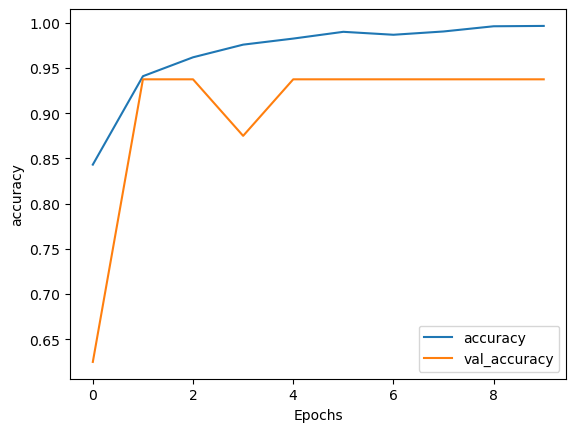

In [29]:
plot_graghs(history, 'accuracy')

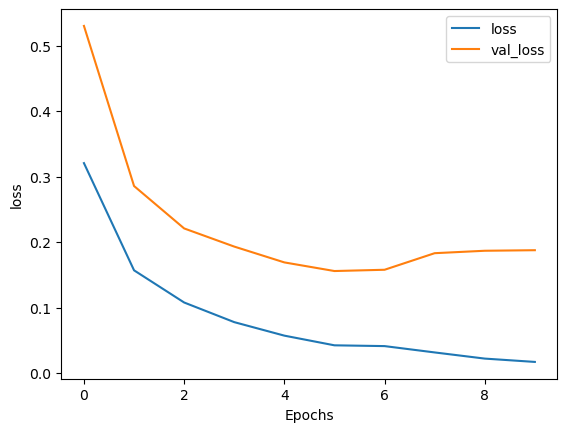

In [30]:
plot_graghs(history, 'loss')

In [33]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size = batch_size,
    shuffle=True
)

Found 624 files belonging to 2 classes.


In [34]:
result = model.evaluate(test_data)
print("Test loss, Test accuracy : ", result)

20/20 [==============================] - 9s 366ms/step - loss: 2.0698 - accuracy: 0.6250
Test loss, Test accuracy :  [2.0697526931762695, 0.625]
